# Demo: Phase transition

In [1]:
from fastsir import DiscreteSIR as sir
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## ER graph, simple contagion

In [2]:
#Network parameters
N = 50000
mean_degree = 10
p = mean_degree/(N-1)
G = nx.fast_gnp_random_graph(N,p)
max_degree = np.max([G.degree(n) for n in G])
edgelist = list(G.edges())

In [3]:
#contagion parameters
r = 0.01 #recovery probability
recovery_probability = r
infection_func = lambda q,k: 1-(1-q)**k
qlist = np.linspace(0.0007,0.0015,20)
q_crit = recovery_probability*(mean_degree/(mean_degree**2-mean_degree))

In [4]:
#simulation parameters
period = np.inf #simulate until no infected node
nb_sample = 100

### Simulation

In [5]:
R_arr = np.zeros((qlist.shape[0],nb_sample)) #results output for order parameter (Number of recovered)
for i,q in enumerate(qlist):
    #define process object for each q
    infection_probability = infection_func(q,np.arange(max_degree+1))
    process = sir(edgelist,recovery_probability,infection_probability)
    #get sample
    for j in range(nb_sample):
        initial_infected_nodes = {np.random.randint(N)}
        process.infect_node_set(initial_infected_nodes)
        process.evolve(period,save_transmission_tree=False,save_macro_state=False) #we do not need to save these
        R_arr[i,j] = process.get_current_macro_state()[3] #get number of recovered at the end
        process.reset()

In [6]:
#get mean and std for runs that go above 1% outbreak size
R_arr_ma = np.ma.array(R_arr, mask = R_arr <= N/100)
R_mean = np.array(R_arr_ma.mean(axis=1))
R_std = np.array(R_arr_ma.std(axis=1))

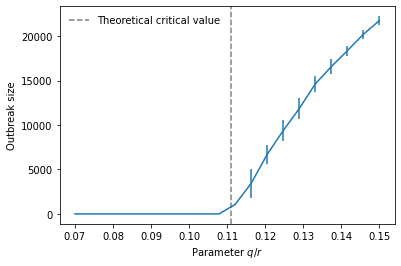

In [7]:
plt.errorbar(qlist/r, R_mean, yerr = R_std)
plt.axvline(q_crit/r,ls='--',color='grey', label='Theoretical critical value')
plt.xlabel(r"Parameter $q/r$")
plt.ylabel(r"Outbreak size")
plt.legend(frameon=False)

## Watts-Strogatz, simple contagion

In [8]:
#Network parameters
N = 50000
k = 10 #connected to 10 nearest neighbors
p = 0.1
G = nx.watts_strogatz_graph(N,k,p)
max_degree = np.max([G.degree(n) for n in G])
edgelist = list(G.edges())

In [9]:
#contagion parameters
r = 0.01 #recovery probability
recovery_probability = r
infection_func = lambda q,k: 1-(1-q)**k
qlist = np.linspace(0.001,0.0025,20)
q_crit = recovery_probability*(mean_degree/(mean_degree**2-mean_degree))

In [10]:
#simulation parameters
period = np.inf #simulate until no infected node
nb_sample = 100

In [11]:
R_arr = np.zeros((qlist.shape[0],nb_sample)) #results output for order parameter (Number of recovered)
for i,q in enumerate(qlist):
    #define process object for each q
    infection_probability = infection_func(q,np.arange(max_degree+1))
    process = sir(edgelist,recovery_probability,infection_probability)
    #get sample
    for j in range(nb_sample):
        initial_infected_nodes = {np.random.randint(N)}
        process.infect_node_set(initial_infected_nodes)
        process.evolve(period,False,False)
        R_arr[i,j] = process.get_current_macro_state()[3] #get number of recovered
        process.reset()

In [12]:
#get mean and std for runs that go above 1% outbreak size
R_arr_ma = np.ma.array(R_arr, mask = R_arr <= N/100)
R_mean = np.array(R_arr_ma.mean(axis=1))
R_std = np.array(R_arr_ma.std(axis=1))

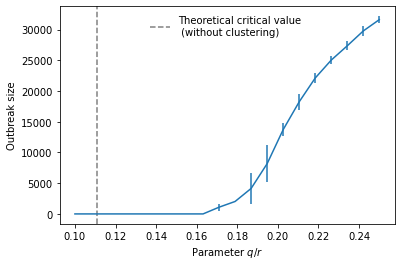

In [13]:
plt.errorbar(qlist/r, R_mean, yerr = R_std)
plt.axvline(q_crit/r,ls='--',color='grey', label='Theoretical critical value \n (without clustering)')
plt.xlabel(r"Parameter $q/r$")
plt.ylabel(r"Outbreak size")
plt.legend(frameon=False)

As expected, clustering is detrimental to disease spreading (simple contagion).

## Watts-Strogatz, complex contagion

In [14]:
#Network parameters
N = 50000
m = 10 #connected to 10 nearest neighbors
p = 0.4
G = nx.watts_strogatz_graph(N,m,p)
max_degree = np.max([G.degree(n) for n in G])
edgelist = list(G.edges())

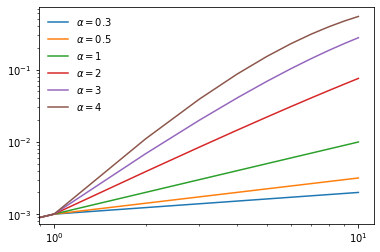

In [15]:
#show contagion profile
infection_func = lambda alpha,q,k: (1-(1-q**(1/alpha))**k)**alpha
klist = np.arange(11)
for alpha in [0.3,0.5,1,2,3,4]:
    plt.loglog(klist,infection_func(alpha,0.001,klist), label=fr"$\alpha = {alpha}$")
plt.legend(frameon=False)

In [16]:
#contagion parameters
r = 0.01 #recovery probability
recovery_probability = r
alpha = 4 #we pick this value
qlist = np.linspace(0.0005,0.0012,20)

In [17]:
#simulation parameters
period = np.inf #simulate until no infected node
nb_sample = 100

In [18]:
R_arr = np.zeros((qlist.shape[0],nb_sample)) #results output for order parameter (Number of recovered)
for i,q in enumerate(qlist):
    #define process object for each q
    infection_probability = infection_func(alpha,q,np.arange(max_degree+1))
    process = sir(edgelist,recovery_probability,infection_probability)
    #get sample
    for j in range(nb_sample):
        initial_infected_nodes = {np.random.randint(N)}
        process.infect_node_set(initial_infected_nodes)
        process.evolve(period, False,False)
        R_arr[i,j] = process.get_current_macro_state()[3] #get number of recovered
        process.reset()

In [19]:
#get mean and std for runs that go above 1% outbreak size
R_arr_ma = np.ma.array(R_arr, mask = R_arr <= N/100)
R_mean = np.array(R_arr_ma.mean(axis=1))
R_std = np.array(R_arr_ma.std(axis=1))

Text(0, 0.5, 'Outbreak size')

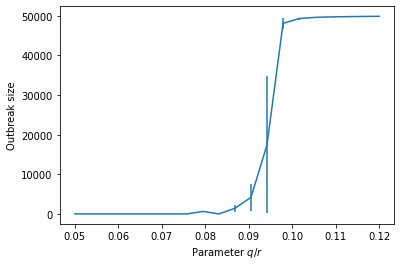

In [20]:
plt.errorbar(qlist/r, R_mean, yerr = R_std)
plt.xlabel(r"Parameter $q/r$")
plt.ylabel(r"Outbreak size")

The nonlinear exponent $\alpha$ helps the spread in clustered populations (reduces the threshold compared to simple contagion). It can also lead to an explosive phase transition (as above), but it depends a lot on the parameters of the contagion and of the structure. In fact, to see an explosive transition, it appears the probability of rewiring $p$ must be at least ~1/5.